# NLP, Scrapping avec Pocket

Le notebook passe en revue plusieurs outils tels que [NLTK](http://www.nltk.org/), les [nuage de mots](https://fr.wikipedia.org/wiki/Nuage_de_mots-cl%C3%A9s), [expressions régulières](https://fr.wikipedia.org/wiki/Expression_r%C3%A9guli%C3%A8re).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Objectifs de la séance

- Compléter les données de l'API avec celles du webscraping
- Visualiser les données
- Nettoyer les données (regexp et nltk)
- Machine Learning "non-supervisé" : tagging automatique avec un tf-idf
- Amélioration de la prédiction de tags grâce à des méthodes de classifications binaires

## Compléter les données de l'API avec celles du webscraping

### Récupérer les données

Retrouver votre CONSUMER_KEY et votre ACCESS_TOKEN. Modifier les codes ci-dessous.

In [2]:
CONSUMER_KEY = "71268-0c68343bf8cd8c34e9029034"
ACCESS_TOKEN = "47d8c59a-c4f5-32be-f9f0-f3fabb"

On importe de nouveau les données du compte pocket.

In [3]:
import requests
from pprint import pprint

items = {
         "consumer_key":CONSUMER_KEY,
         "access_token":ACCESS_TOKEN,
         "detailsType": "complete"
        }

dict_pocket = requests.post('https://getpocket.com/v3/get', data = items).json()['list']

### En cas de probleme, vous pouvez importer les données à partir du .json

On va donc directement importer les données au format json.

In [4]:
import json
from pprint import pprint

with open('./data_pocket.json') as fp:    
    dict_pocket = json.load(fp)

for k, v in dict_pocket.items():
    print(k)
    pprint(v)
    break

{'1003565100': {'authors': {'55834601': {'author_id': '55834601',
                                         'item_id': '1003565100',
                                         'name': 'Grafikart.fr',
                                         'url': ''}},
                'excerpt': 'Ionic est un framework qui va vous permettre de '
                           'créer des applications mobiles en utilisant des '
                           'technologies Web. Ionic se base pour cela sur '
                           "d'autres frameworks / technologies qui ont fait "
                           'leurs preuves.  Avant de pouvoir commencer, il '
                           'nous faut évidemment commencer par installer '
                           "l'outil.",
                'favorite': '0',
                'given_title': 'Tutoriel Vidéo Apache Cordova Ionic Framework',
                'given_url': 'https://www.grafikart.fr/tutoriels/cordova/ionic-framework-641',
                'has_image': '0',
      

On créé une DataFrame avec les éléments souhaités (item_id, resolved_url, resolved_title, excerpt, tags).

### Mise en forme des données

In [5]:
dict_to_df = {}

keys = ['resolved_url', 'resolved_title', 'excerpt', 'tags']

for (k,v) in dict_pocket.items():
    dict_to_df[k] = dict(zip(keys, [v[key] for key in keys if key in v]))

In [6]:
import pandas as p
df_pocket = p.DataFrame.from_dict(dict_to_df, orient = "index")
df_pocket.head()

,resolved_title,resolved_url,excerpt,tags
1003565100,Tutoriel Vidéo Apache CordovaIonic Framework,https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,"{'mobile app': {'item_id': '1003565100', 'tag'..."
1008275819,Color Hunt,http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,"{'lewagon': {'item_id': '1008275819', 'tag': '..."
1011618630,Out-of-Core Dataframes in Python: Dask and Ope...,https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...","{'data science': {'item_id': '1011618630', 'ta..."
1014684096,A/B Testing with Hierarchical Models in Python,https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...","{'abtest': {'item_id': '1014684096', 'tag': 'a..."
1016233829,Getting started with the Web,https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,"{'mdn': {'item_id': '1016233829', 'tag': 'mdn'..."


On met en forme la colonne "tags".

In [7]:
df_pocket['tags'] = df_pocket['tags'].apply(lambda x: list(x.keys()) if x==x else x)
df_pocket.rename(columns = {'resolved_url':'url', 'resolved_title': 'title'}, inplace = True)
df_pocket.head()

,title,url,excerpt,tags
1003565100,Tutoriel Vidéo Apache CordovaIonic Framework,https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,[mobile app]
1008275819,Color Hunt,http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,[lewagon]
1011618630,Out-of-Core Dataframes in Python: Dask and Ope...,https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...",[data science]
1014684096,A/B Testing with Hierarchical Models in Python,https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...",[abtest]
1016233829,Getting started with the Web,https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,"[mdn, documentation]"


### Regular expression 

Par [ici](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_eco_5d_Travailler_du_texte_les_expressions_regulieres.html#td2aeco5dtravaillerdutextelesexpressionsregulieresrst).

Les expressions régulières (ou regular expression, regexp) servent à extraire des données de texte, ou à valider des données utilisateurs (lorsqu'un utilisateur rempli un formulaire par exemple). Voici les principaux caractères à connaître.

In [8]:
from ensae_teaching_cs.doc import regex_cases
regex_cases()

,Cas,Explications
0,-------,Bases
1,a,a
2,-------,Quantificateurs
3,abc?,ab suivi par 0 ou 1 c
4,abc*,ab suivi par 0.. c
5,abc+,ab suivi par 1.. c
6,abc{3},ab suivi par 3 c
7,"abc{3,5}","ab suivi par 3, 4 ou 5 c"
8,,Groupes
9,(abc)+,1..8 abc


Pour utiliser les regexp avec python, on fait appel au module "re", de la manière suivante : 

In [9]:
import re
string = "abc abccc abc ab bc"
print(re.compile("\\w+").findall(string))

['abc', 'abccc', 'abc', 'ab', 'bc']


### Exercice 1

Extraire le domaine en utilisant des regexp. Le stocker dans un champs du DataFrame. Vous pouvez utiliser ce super outil : https://www.debuggex.com/

### Ajout des données issues du webscraping

#### Contenu des pages présentes dans pocket

In [10]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

def words_htmltag(url):
    print(url)
    try: 
        html = requests.get(url).text
        soup = BeautifulSoup(html, 'lxml')
        words_dict = {}
        for html_tag in ['h1','h2','h3','p', 'article']:
            for e in soup.findAll(html_tag):
                text = e.get_text()
                words = re.split(r'\s+', text)
                # r'\s+' c est une expression reguliere.
                # celle-ci permet de splitter sur " ", "\t", "\n", "\r" meme s il y en a plusieurs d affilee
                words_dict[html_tag]=words 
        return words_dict
    except:
        return "scraper banned"

df_sample = df_pocket.ix[:2]

df_sample['html_soup'] = df_sample['url'].apply(lambda x: words_htmltag(x))

https://www.grafikart.fr/tutoriels/cordova/ionic-framework-641
http://www.colorhunt.co


/home/athean/anaconda3/envs/ensae/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
#df_sample.to_csv('./df_pocket.csv', index=False)

In [12]:
import pandas as p
import ast
df_pocket = p.read_csv('./df_pocket.csv')
df_pocket['html_soup'] = df_pocket['html_soup'].apply(lambda x : ast.literal_eval(x) if x != "scraper banned" else x)
df_pocket['tags'] = df_pocket['tags'].apply(lambda x : ast.literal_eval(x) if x == x else x)
df_pocket.head()

,tags,url,excerpt,title,domain,html_soup
0,[mobile app],https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,Tutoriel Vidéo Apache CordovaIonic Framework,grafikart.fr,"{'h2': ['Petit', 'tour', 'du', 'propriétaire']..."
1,[lewagon],http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,Color Hunt,colorhunt.co,{}
2,[data science],https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...",Out-of-Core Dataframes in Python: Dask and Ope...,jakevdp.github.io,"{'h2': ['Pubs', 'of', 'the', 'British', 'Isles..."
3,[abtest],https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...",A/B Testing with Hierarchical Models in Python,blog.dominodatalab.com,"{'h2': ['Recent', 'Posts'], 'h3': ['Related'],..."
4,"[mdn, documentation]",https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,Getting started with the Web,developer.mozilla.org,"{'h2': ['Mozilla'], 'h3': ['How', 'the', 'web'..."


## Visualiser les données

Avant de sortir des statsitiques sur les termes que nous avons récupéré, il peut etre utile de les visualiser. Cela donne toujours des idées de voir les données. Pour cela on va utiliser la librairie [wordcloud](https://github.com/amueller/word_cloud).

In [13]:
! pip install wordcloud

You are using pip version 9.0.0, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
print(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white")

{'herself', 'she', 'then', "why's", 'cannot', 'k', "haven't", 'below', 'these', 'just', 'an', 'same', 'them', 'or', 'can', 'that', 'own', 'it', 'your', "you're", 'how', 'further', 'nor', 'in', 'could', "isn't", "we're", 'www', 'at', "aren't", 'ourselves', "they've", 'into', 'what', 'are', "here's", "i'd", 'on', 'hers', 'he', 'under', 'a', "who's", 'yourselves', "couldn't", 'any', 'where', 'had', 'again', "they'd", 'do', 'http', 'to', 'than', 'up', 'after', 'theirs', 'too', "wasn't", 'does', 'myself', 'if', 'has', 'doing', 'would', 'we', 'when', 'down', 'they', "weren't", "it's", 'so', 'were', "there's", 'only', 'yours', 'themselves', 'which', "they're", 'itself', 'being', 'shall', 'but', 'off', "how's", 'is', "that's", 'because', "he's", "she'll", 'ever', 'more', 'who', "i'm", 'against', 'while', "doesn't", "where's", 'the', 'our', 'her', "didn't", 'be', 'before', "he'll", 'above', 'about', 'with', 'did', 'been', "don't", "shouldn't", 'from', 'most', "i've", "wouldn't", 'by', 'having',

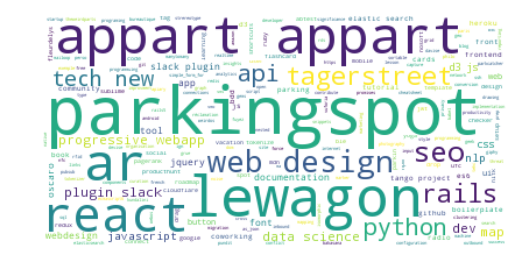

In [16]:
tags_string = ' '.join(df_pocket['tags'].apply(lambda x: ' '.join(x) if x==x else ''))
wordcloud.generate(tags_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Exercice 2

### Exercice 2 - 1

Pour les webmasters qui cherchent à optimiser le référencement de leur site dans le moteur de recherche Google, il est important d'avoir une cohérence des termes utilisés dans les titles, balises h1 et urls. Faire des wordcloud sur ces champs et voir si c'est respecté ici.

### Exercice 2 - 2

Analyser les termes présents dans les champs h2, h3, et p de html_soup et, dans l'excerpt. A votre avis, faudra-t-il donner le même poids aux mots contenus dans ces champs qu'à ceux contenus dans les h1, title et urls ? Si certains mots fréquents vous surprennent, il peut s'agir d'un biais dans les sites bookmarqués : n'hésitez pas à lister les urls correspondantes !

### Exercice 2 - 3

En se restreignant aux urls qui ont des tags, comparer les nuages des mots contenus dans les champs h1, title et urls avec les tags. Qu'en déduisez-vous ?

Astuce:  Penser à étoffer les stopwords en fonction des résultats (par exemple, il y a beaucoup "de", "le", "la" (l'objet STOPWORDS proposé dans wordcloud est en anglais).

## Nettoyer les données (regexp et nltk)

Mais avant tout, nous devrions augmenter la qualité de nos données (en améliorant les parsers et la liste des stopwords). C'est l'objet de cette section.

In [17]:
words = ' '.join([title_string,url_string,h1_string,h2_string,h3_string,excerpt_string])
# on ne conserve que les mots
words_string = re.sub('[^A-Za-z ]','', words)
#on "nettoie les espaces"
words_string = re.sub('\s+',' ', words_string)
words_string

'Tutoriel Vido Apache CordovaIonic Framework Color Hunt OutofCore Dataframes in Python Dask and OpenStreetMap AB Testing with Hierarchical Models in Python Getting started with the Web Le Wagon UI components shakacodereactonrails Le Wagon Alumni Nocturne Opus No Frederic Chopin Piano Tutorial Synthesia ES Promises in Depth Jupyter Notebook Viewer Introduction lanalyse de texte avec nltk Tokenization CamFind API Documentation Build an Elasticsearch Index with PythonMachine Learning Series Part The MustHave Discovery Tool for every Media Professional Python NLTK WTF Chapter Notes on things that dont work right Google Maps Geolocation Tracking in Realtime with JavaScript The Definitive Guide to Natural Language Processing lewagonrailsstylesheets Productivity Tips for Programmers with ADHD EquityOwl No Cash No Salaries Just Equity React For Beginners Learn Enough Text Editor to Be Dangerous Michael Hartl Mapbox The New WordPresscom Why Proxima Nova Is Everywhere PayByPhone Adds NFC in San 

In [18]:
! pip install nltk

You are using pip version 9.0.0, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Nltk contient un corpus de stopwords en plusieurs langues. On peut enrichir la liste déjà créée.

In [19]:
import nltk
stopwords_fr_ntlk = set(nltk.corpus.stopwords.words('french'))
stopwords_en_ntlk = set(nltk.corpus.stopwords.words('english'))
stopwords_clean = [ l.lower() for l in list(stopwords.union(stopwords_fr_ntlk).union(stopwords_en_ntlk))]
stopwords_clean[:20]

['herself',
 'she',
 "why's",
 'org',
 'k',
 'sur',
 'just',
 'same',
 'or',
 'that',
 'it',
 'your',
 'use',
 'ayantes',
 'soyez',
 "you're",
 'further',
 'in',
 'github',
 'could',
 'until']

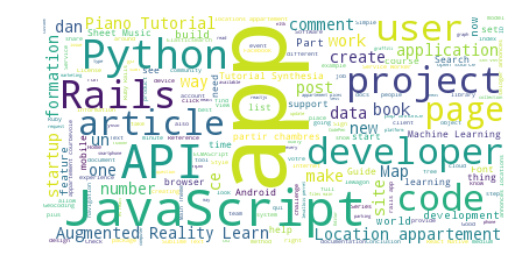

In [20]:
wordcloud.generate(words_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

On applique tout ça à df_pocket.

In [21]:
def words_cleaning(url,title,excerpt,html_soup):
    url_clean = url_cleaning(url)
    title_clean = nan_to_string(title)
    excerpt_clean = nan_to_string(excerpt)
    h1_clean = hx_cleaning(html_soup,'h1')
    h2_clean = hx_cleaning(html_soup,'h2')
    h3_clean = hx_cleaning(html_soup,'h3')
    p_clean = p_cleaning(html_soup)
    words = ' '.join([url_clean, title_clean, excerpt_clean, h1_clean, h2_clean, h3_clean, p_clean])
    words_clean = re.sub('[^A-Za-z ]','', words)
    words_clean = re.sub('\s+',' ', words_clean)
    words_list = words_clean.split(' ')
    return ' '.join([w.lower() for w in words_list if w not in stopwords_clean])

In [22]:
df_pocket['words_string'] = np.vectorize(words_cleaning)(df_pocket['url'], \
                                                         df_pocket['title'], \
                                                         df_pocket['excerpt'], \
                                                         df_pocket['html_soup'])
df_pocket.head()

,tags,url,excerpt,title,domain,html_soup,h1,h2,h3,p,words_string
0,[mobile app],https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,Tutoriel Vidéo Apache CordovaIonic Framework,grafikart.fr,"{'h2': ['Petit', 'tour', 'du', 'propriétaire']...",Tutoriel Vidéo Apache CordovaIonic Framework ...,Petit tour du propriétaire,La compilation,,grafikart tutoriels cordova ionic framework tu...
1,[lewagon],http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,Color Hunt,colorhunt.co,{},,,,,colorhunt color hunt home create likes about a...
2,[data science],https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...",Out-of-Core Dataframes in Python: Dask and Ope...,jakevdp.github.io,"{'h2': ['Pubs', 'of', 'the', 'British', 'Isles...",Comments,Pubs of the British Isles¶,Dask Arrays¶,This post was written entirely in the IPython ...,jakevdp core dataframes python outofcore dataf...
3,[abtest],https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...",A/B Testing with Hierarchical Models in Python,blog.dominodatalab.com,"{'h2': ['Recent', 'Posts'], 'h3': ['Related'],...",Conclusion,Recent Posts,Related,Get Data Science Updates,dominodatalab ab testing hierarchical models p...
4,"[mdn, documentation]",https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,Getting started with the Web,developer.mozilla.org,"{'h2': ['Mozilla'], 'h3': ['How', 'the', 'web'...",Getting started with the Web,Mozilla,How the web works,Content is available under these licenses.,developer mozilla us docs learn gettingstarted...


## Natural Language Processing et tf-idf

Lire [introduction au NLP](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#td2atd5traitementautomatiquedeslanguesenpythonrst)

### Exercice 3

S'inspirer de [introduction à nltk](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#introduction-a-nltk) et analyser les principaux termes de recherche des documents.

### Exercice 4

S'inspirer de [tf-idf à la main](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#analyse-des-donnees-textuelles-td-idf-similarite-cosine-et-n-grams) ou de [tf-idf avec nltk](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#requeter-les-donnees-google-avec-tf-idf) et faire un moteur de recherche. Trouver les 5 documents les plus pertinents pour les mots-clés ['python','data', 'science']. Quels avantages a votre moteur de recherche par rapport à celui proposé par pocket ?

## Catégorisation automatique avec une méthode de machine learning non-supervisé : LDA

### Exercice 5

S'inspirer de [LDA](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/) et [un exemple de LDA](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_some_nlp.html#lda) et proposer une catégorisation automatique des documents. Comparer aux tags initiaux.